In [53]:
using LinearAlgebra
using Plots
using Test
using Printf

##########################
# Méthodes Quasi-Newton #
##########################
function BFGS(sₖ, yₖ, Hₖ, Bₖ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

SR1 (generic function with 1 method)

In [226]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

function lineSearch(problem, x₀, Δ; affichage = false, maxiter = 1000, ϵ = 10e-8, update = BFGS)
    g = problem.gradient
    gₖ = g(x₀) # Initialisation du gradient au point initial (x₀ := centre de la région de confiance)
    Hₖ = I # Initialisation de Hₖ et de Bₖ
    Bₖ = I
    dₖ = -Hₖ*gₖ # Direction de descente (suivant la méthode BFGS)
    # Calcul de la longueur du pas α minimisant f(x₀ + α*sₖ) (exact dans le cas d'une quadratique convexe)
    B = problem.Hess(x₀)
    αₖ = -dot(gₖ, dₖ)/dot(dₖ, B*dₖ)
    if(dot(dₖ, Bₖ*dₖ) < 0)
        αₖ = -100*Δ/norm(dₖ)
    elseif(αₖ < 0)
        αₖ = 2*Δ/norm(dₖ)
    end
    #if(dot(sₖ, B*sₖ) < 0) 
    #    αₖ = Δ/norm(sₖ)
    #else
    #    αₖ = -dot(gₖ, sₖ)/dot(sₖ, B*sₖ)
    #end
    sₖ = αₖ*dₖ # Pas optimal suivant la direction de descente
    # Initilisation de pₖ := Σᵏᵢ₌₁ sᵢ 
    # (c'est le vecteur qui correspondra au minimum ou qui s'en rapprochera le long de la frontière de la RC)
    pₖ = sₖ 
    yₖ = g(x₀ + pₖ) - gₖ
    @printf("%9s %9s %9s %6s %9s %9s %9s \n", "dₖᵗBdₖ", "dₖᵗBₖdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||")
    @printf("%8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", dot(dₖ, B*dₖ), dot(dₖ, Bₖ*dₖ), dot(gₖ, dₖ), αₖ, 
        problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B))
    gₖ += yₖ
    # Sauvegarde à chaque itération de pₖ et de sa norme (pour affichage graphique)
    NormP = [norm(pₖ)]
    P = [pₖ]
    B = problem.Hess(x₀)
    NormB = [norm(Bₖ - B)]
    F = [problem.fonction(x₀ + pₖ)]
    eig = []
    for k = 0:(maxiter-1)
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Suppresion de la dernière mise à jour comme on revient en arrière
            pop!(NormP)
            pop!(P)
            pop!(F)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(pₖ, sₖ)
            c = dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            pₖ += τ*sₖ
            push!(NormP, norm(pₖ))
            push!(P, pₖ)
            push!(F, problem.fonction(x₀ + pₖ))
            @printf("%35s %8.1e %8.1e \n", "sortie de la région de confiance : ", problem.fonction(x₀ + pₖ), norm(pₖ))
            return(pₖ, NormP, k, P, NormB, F, eig)
        end
        if(norm(gₖ) <= ϵ) # Convergence
            return(pₖ, NormP, k, P, NormB, F, eig)
        end
        # Mise à jour de Hₖ par la méthode BFGS
        Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ)
        dₖ = -Hₖ*gₖ
        # Recherche de la longueur du pas α minimisant f(p + α*sₖ)
        #if(dot(sₖ, B*sₖ) < 0)
        #    αₖ = Δ/norm(sₖ)
        #else
        #    αₖ = -dot(gₖ, sₖ)/dot(sₖ, B*sₖ)
        #end
        αₖ = -dot(gₖ, dₖ)/dot(dₖ, B*dₖ)
        if(αₖ < 0)
            αₖ = Δ/norm(dₖ)
        end
        if(dot(dₖ, Bₖ*dₖ) < 0)
            αₖ = -10*Δ/norm(dₖ)
        elseif(αₖ < 0)
            αₖ = 2*Δ/norm(dₖ)
        end
        sₖ = αₖ*dₖ
        pₖ += sₖ
        yₖ = g(x₀ + pₖ) - gₖ
        @printf("%8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", dot(dₖ, B*dₖ), dot(dₖ, Bₖ*dₖ), dot(gₖ, dₖ), αₖ, 
            problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B))
        gₖ += yₖ
        # Concaténation
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(P, pₖ)
        push!(NormB, norm(Bₖ - B))
        push!(eig, eigvals(Bₖ))
    end
    return(pₖ, NormP, maxiter, P, NormB, F, eig)
end

lineSearch (generic function with 1 method)

In [132]:
function CG(problem, x₀, Δ; maxiter = 1000, ϵ = 10e-8)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    pₖ = -rₖ
    k = 0
    xₖ = x₀
    X = []
    normP = []
    F = []
    @printf("%6s %9s %9s \n", "αₖ", "f(xₖ)", "||pₖ||")
    while(norm(rₖ) > ϵ && k <= maxiter)
        if(dot(pₖ, A*pₖ) < 0)
            αₖ = Δ/norm(pₖ)
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, A*pₖ)
        end
        xₖ += αₖ*pₖ
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            return(xₖ, k, normP, F)
        end
        rₖ = problem.gradient(xₖ)
        βₖ = dot(rₖ, A*pₖ)/dot(pₖ, A*pₖ)
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        @printf("%8.1e %8.1e %8.1e \n", αₖ, problem.fonction(xₖ), norm(xₖ - x₀))
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
    end
    return(xₖ, k, normP, F)
end

CG (generic function with 1 method)

In [416]:
# d = [10e-8, 8e-8, 4e-8, 3e-8, 2e-8, 1e-8] # matrice quasi-singulière et petit conditionnement
# d = [10e-3, 8, 4e3, 3e4, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-signulière avec gros contionemment (1)
# d = [10e-4, 8e3, 40, 3000, 2e-8, 10e-2] # matrice quasi-signulière avec gros contionemment (2)
d = [15, 35, 55, 75, 95, 115] # matrice SDP

D = Diagonal(d)
A = rand(6, 6)
Q, R = qr(A)
A = transpose(Q)*D*Q
b = [1, 2, 3, 4, 5, 6]

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = [0, 0, 0, 0, 0, 0]
quadratic = problem(f, g, B)

problem(f, g, B)

conditionnement de la Hessienne : 13.880269425647288
eigvals de B : [15, 35, 55, 75, 95, 115]

Méthode BFGS
   dₖᵗBdₖ   dₖᵗBₖdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ|| 
 4.6e+03  9.1e+01 -9.1e+01  2.0e-02 -8.9e-01  1.9e-01  1.8e+02 
 7.9e+02  3.2e+01 -3.2e+01  4.1e-02 -1.5e+00  4.0e-01  1.6e+02 
 1.0e+03  1.0e+01 -1.0e+01  1.0e-02 -1.6e+00  4.2e-01  1.5e+02 
 6.5e+00  7.6e-02 -7.6e-02  1.2e-02 -1.6e+00  4.2e-01  1.2e+02 
 2.6e-01  5.0e-03 -5.0e-03  1.9e-02 -1.6e+00  4.2e-01  7.0e+01 
 1.0e-02  2.4e-04 -2.4e-04  2.4e-02 -1.6e+00  4.2e-01  4.1e+01 
 3.1e-31  3.1e-31 -3.1e-31  1.0e+00 -1.6e+00  4.2e-01  1.6e-11 

Valeurs propres de Bₖ en fonction des itérations
itération 1 : [0.736215, 1.0, 1.0, 1.0, 1.0, 69.32]
itération 2 : Complex{Float64}[78.6026+0.0im, 22.9322+0.0im, 0.694852+0.0im, 1.0+2.68814e-15im, 1.0-2.68814e-15im, 1.0+0.0im]
itération 3 : [112.247, 75.1674, 15.085, 0.988894, 1.0, 1.0]
itération 4 : [114.492, 88.3406, 74.7923, 15.009, 0.937512, 1.0]
itération 5 : [0.95066

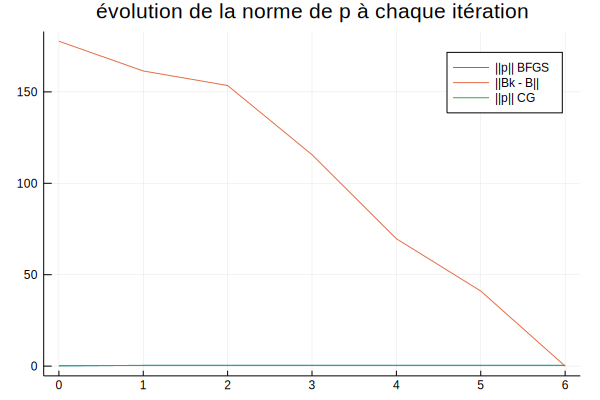

In [417]:
println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))
println("eigvals de B : ", d)
println("")

Δ = Inf
println("Méthode BFGS")
p, NormP, iter, P, normB, F, eig = lineSearch(quadratic, x₀, Δ, maxiter = 6, ϵ = 10e-17, update = BFGS); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter
    println("itération ", i, " : ", eig[i])
end
# passé 10e-11 la précision n'est plus suffisante pour arrêter l'algo 
# en N itérations et la reconstitution de la Hessienne se déteriore.

println("")
println("Méthode du GC")
pᵧ, iterᵧ, Pᵧ, Fᵧ = CG(quadratic, x₀, Δ, maxiter = 6, ϵ = 10e-17)

println("")
println("Comparaison des solutions")
println("(BFGS)  p = $p")
println("(CG)    p = $pᵧ")
println("A⁻¹b - x₀ = ", -A\b - x₀)
println("")
@printf("%22s %8.1e \n","(BFGS) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(CG)   ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
plot(0:iter, NormP, label = "||p|| BFGS", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")

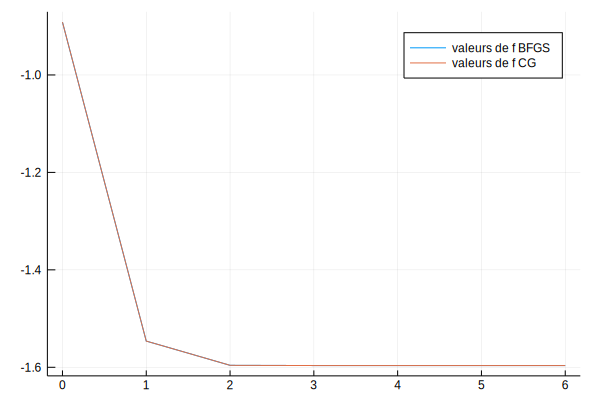

In [418]:
plot(0:iter, F, label = "valeurs de f BFGS")
plot!(0:(iterᵧ-1), Fᵧ, label = "valeurs de f CG")

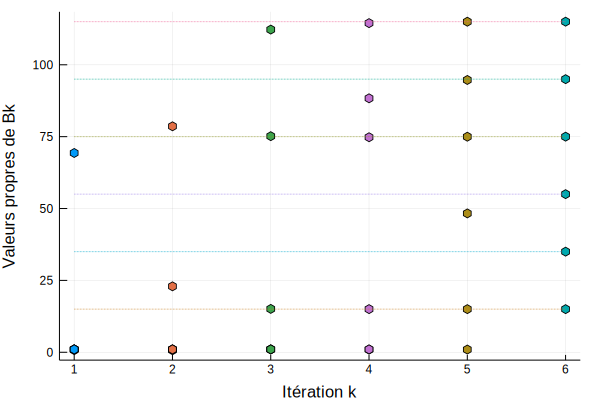

In [423]:
# Graphe de valeurs propres
# Il se peut que selon l'ordinateur utilsé, la fonction egvals trouve des valeurs propres Complexes 
# (avec la partie imaginaire nulle). La commande reinterpret permet de transformer un vecteur de nombres complexes de taille N
# en un vecteur de nombres réels de taille 2N.
# Mais ceci ne peut-être fait qu'au cas par cas car si réalisé sans vérification sur les autres vecteurs, 
# nous nous retrouvons à transformer un vecteur de réel de taille N en un vecteur de réel de taille N/2 
# et nous perdons alors la moitié de l'information désirée.

# -> Regarder la capsule plus haut pour savoir quelles valeurs propres sont affichées en complexe

plot(ones(6), eig[1], marker = (:hexagon), line = false, legend = false, xlabel = "Itération k", ylabel = "Valeurs propres de Bk")
# A la deuxième itérations les valeurs propres sont complexes
zfl = reinterpret(Float64, eig[2])
zre = @view zfl[1:2:end-1]
plot!(2*ones(6), zre, marker = (:hexagon), line = false, label = false)
plot!(3*ones(6), eig[3], marker = (:hexagon), line = false)
plot!(4*ones(6), eig[4], marker = (:hexagon), line = false, label = false)
plot!(5*ones(6), eig[5], marker = (:hexagon), line = false, label = false)
plot!(6*ones(6), eig[6], marker = (:hexagon), line = false, label = false)
u = eigvals(A)
plot!(1:6, u[1]*ones(6), line = :dot)
plot!(1:6, u[2]*ones(6), line = :dot)
plot!(1:6, u[3]*ones(6), line = :dot)
plot!(1:6, u[4]*ones(6), line = :dot)
plot!(1:6, u[5]*ones(6), line = :dot)
plot!(1:6, u[6]*ones(6), line = :dot)

In [395]:
# Quadratique non-convexe
# d = [6, 5, -0.03, 2, 0, 4.8, 1, 7, 8, 9, 1.5] # Cas où SR1 fonctionne mal (division par 0)
d = [6, 5, 1, 2, 10, 4.8, -0.01, 7, 8, 9, 1.5]

D = Diagonal(d)
A = rand(11, 11)
Q, R = qr(A)
A = transpose(Q)*D*Q
b = [1, 2, 3, 4, 5, 6, 1, 1, 1, 1, 1]

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(11)
quadratic = problem(f, g, B)

problem(f, g, B)

conditionnement de la Hessienne : 1963.0637234249557
eigvals de B : [6.0, 5.0, 1.0, 2.0, 10.0, 4.8, -0.01, 7.0, 8.0, 9.0, 1.5]

Méthode BFGS
   dₖᵗBdₖ   dₖᵗBₖdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ|| 
 5.1e+02  9.6e+01 -9.6e+01  1.9e-01 -9.0e+00  1.8e+00  1.7e+01 
 7.9e+01  3.1e+01 -3.1e+01  4.0e-01 -1.5e+01  3.8e+00  1.6e+01 
 1.2e+02  2.3e+01 -2.3e+01  1.8e-01 -1.7e+01  4.7e+00  1.5e+01 
 8.1e+00  3.5e+00 -3.5e+00  4.3e-01 -1.8e+01  5.1e+00  1.3e+01 
 6.7e+00  7.0e+00 -7.0e+00  1.0e+00 -2.2e+01  8.7e+00  1.2e+01 
 6.5e+01  2.7e+01 -2.7e+01  4.1e-01 -2.7e+01  1.6e+01  1.0e+01 
 1.7e+01  2.8e+01 -2.8e+01  1.6e+00 -4.9e+01  4.9e+01  9.1e+00 
-3.6e+02  3.2e+02 -3.2e+02  4.1e-01 -2.1e+02  1.5e+02  7.3e+00 
sortie de la région de confiance :  -1.2e+02  1.0e+02 

Valeurs propres de Bₖ en fonction des itérations
itération 1 : [0.727228, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.30467]
itération 2 : [8.23421, 3.72556, 0.437597, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
itération 3 

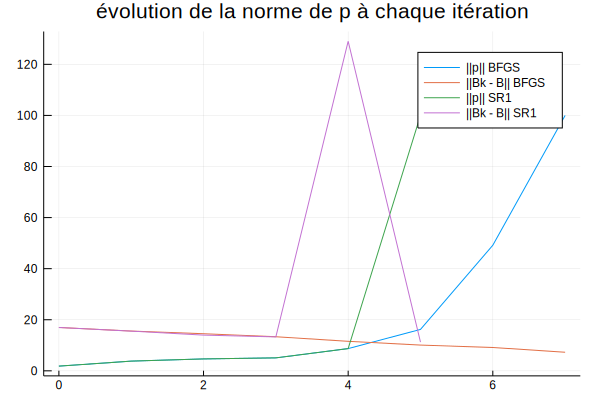

In [398]:
println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))
println("eigvals de B : ", d)
println("")

Δ = 100

println("Méthode BFGS")
p, NormP, iter, P, normB, F, eig = lineSearch(quadratic, x₀, Δ, maxiter = 20, ϵ = 10e-17, update = BFGS); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iter
    println("itération ", i, " : ", eig[i])
end

println("")
println("Méthode SR1")
pᵧ, NormPᵧ, iterᵧ, Pᵧ, normBᵧ, Fᵧ, eigᵧ = lineSearch(quadratic, x₀, Δ, maxiter = 20, ϵ = 10e-17, update = SR1); 
println("")
println("Valeurs propres de Bₖ en fonction des itérations")
for i = 1:iterᵧ
    println("itération ", i, " : ", eigᵧ[i])
end

println("")
println("Comparaison des solutions")
println("(BFGS)  p = $p")
println("(SR1)   p = $pᵧ")
println("A⁻¹b - x₀ = ", -A\b - x₀)
println("")
@printf("%22s %8.1e \n","(BFGS) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(SR1)  ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
plot(0:iter, NormP, label = "||p|| BFGS", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B|| BFGS")
plot!(0:iterᵧ, NormPᵧ, label = "||p|| SR1")
plot!(0:iterᵧ, normBᵧ, label = "||Bk - B|| SR1")


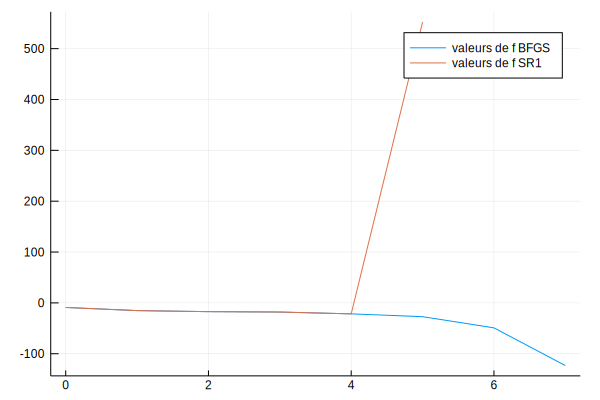

In [399]:
plot(0:iter, F, label = "valeurs de f BFGS")
plot!(0:iterᵧ, Fᵧ, label = "valeurs de f SR1")

In [391]:
function createQuadraticConvexe(N = 10)
    b = rand(N)
    C = rand(N, N)
    @test det(C) != 0
    A = transpose(C)*C # Obtention d'une matrice symétrique définie positive (si C non singulier)
    f(x) = dot(b, x) + 0.5*dot(x, A*x)
    g(x) = b + A*x
    B(x) = A
    return(problem(f, g, B))
end

createQuadraticConvexe (generic function with 2 methods)

In [371]:
N = 30
quadratic = createQuadraticConvexe(N)
x₀ = zeros(N);
A = quadratic.Hess(x₀)
b = quadratic.gradient(x₀) - A*x₀
println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))
println("valeurs propres de la Hessienne : ", eigvals(A))

conditionnement de la Hessienne : 286261.8377383549
valeurs propres de la Hessienne : [0.000837099, 0.00614489, 0.0333009, 0.0530615, 0.115812, 0.152532, 0.480157, 0.516432, 0.571639, 0.719996, 0.808948, 1.13522, 1.20937, 1.55663, 1.68055, 1.88119, 2.00154, 2.09209, 2.36747, 3.092, 3.16392, 3.44714, 3.93618, 4.63193, 5.1427, 5.82146, 6.77736, 7.2281, 8.8135, 236.622]


Méthode BFGS
   dₖᵗBdₖ   dₖᵗBₖdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ|| 
 2.1e+03  1.2e+01 -1.2e+01  5.7e-03 -3.4e-02  2.0e-02  2.4e+02 
 8.9e+00  4.1e+00 -4.1e+00  4.7e-01 -1.0e+00  1.1e+00  1.5e+01 
 1.1e+01  4.2e+00 -4.2e+00  3.9e-01 -1.8e+00  2.2e+00  1.4e+01 
 8.1e+00  5.1e+00 -5.1e+00  6.3e-01 -3.4e+00  4.8e+00  1.3e+01 
 1.7e+01  1.1e+01 -1.1e+01  6.1e-01 -6.7e+00  1.1e+01  1.2e+01 
 3.2e+01  1.5e+01 -1.5e+01  4.8e-01 -1.0e+01  1.7e+01  1.1e+01 
 2.3e+01  1.2e+01 -1.2e+01  4.9e-01 -1.3e+01  2.3e+01  1.1e+01 
 2.0e+01  1.2e+01 -1.2e+01  6.0e-01 -1.7e+01  3.0e+01  9.8e+00 
 2.2e+01  8.8e+00 -8.8e+00  3.9e-01 -1.9e+01  3.3e+01  9.3e+00 
 1.2e+01  5.9e+00 -5.9e+00  4.8e-01 -2.0e+01  3.6e+01  8.3e+00 
 1.0e+01  4.3e+00 -4.3e+00  4.3e-01 -2.1e+01  3.8e+01  7.4e+00 
 3.8e+00  2.6e+00 -2.6e+00  6.8e-01 -2.2e+01  4.0e+01  6.6e+00 
 3.6e+00  3.4e+00 -3.4e+00  9.3e-01 -2.3e+01  4.4e+01  5.9e+00 
 3.8e+00  3.9e+00 -3.9e+00  1.0e+00 -2.5e+01  4.9e+01  5.5e+00 
 1.1e+01  6.2e+00 -6.2e

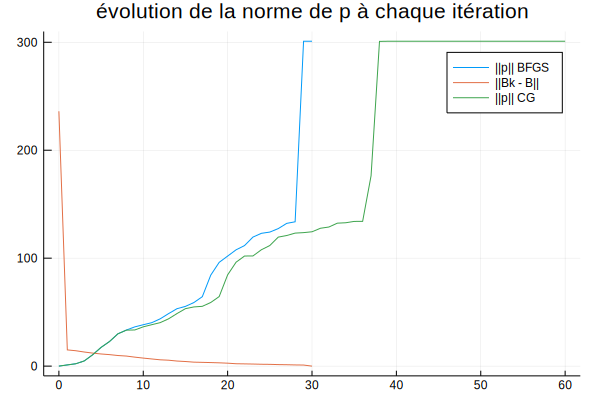

In [372]:
Δ = Inf
println("Méthode BFGS")
p, NormP, iter, P, normB, F, eig = lineSearch(quadratic, x₀, Δ, maxiter = 60, ϵ = 10e-12, update = BFGS); 

println("")
println("Méthode du GC")
pᵧ, iterᵧ, Pᵧ, Fᵧ = CG(quadratic, x₀, Δ, maxiter = 60, ϵ = 10e-12)

println("")
println("Comparaison des solutions")
println("(BFGS)  p = $p")
println("(CG)    p = $pᵧ")
println("A⁻¹b - x₀ = ", -A\b - x₀)
println("")
@printf("%22s %8.1e \n","(BFGS) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(CG)   ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
plot(0:iter, NormP, label = "||p|| BFGS", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")

In [373]:
T = zeros(length(P) - 1, N) # les sₖ
for i = 2:length(P)
    for j = 1:N
        T[i - 1, j] = P[i][j] - P[i-1][j]
    end
end
A = quadratic.Hess(x₀)
print(T*A*transpose(T))

[1.93366 2.26598e-16 2.97184e-15 5.04288e-15 1.82865e-15 2.19266e-15 -1.73676e-14 2.21654e-14 2.03096e-14 -1.53565e-14 -3.02149e-14 -2.44181e-14 2.70557e-14 3.32221e-14 1.29336e-14 1.14537e-14 -1.60226e-13 9.96142e-14 7.87279e-14 1.4248e-14 -9.33443e-15 2.09784e-14 -5.10721e-13 3.35669e-13 1.80324e-13 1.83429e-13 -4.17833e-13 7.29278e-13 -9.40878e-11 9.37257e-11; -1.79488e-15 1.63702 6.36465e-15 6.65677e-16 -9.34803e-15 -6.59925e-15 -1.77899e-14 2.73662e-14 2.89676e-14 -2.16793e-14 -3.70165e-14 -8.82817e-14 -6.63451e-15 1.70948e-14 4.03118e-14 4.75905e-14 1.89174e-14 -1.19992e-14 -1.15447e-13 -1.01854e-13 -4.70847e-14 3.48488e-13 -3.16929e-13 -5.7412e-14 -8.50136e-15 -7.73431e-14 8.06378e-13 -2.10031e-12 2.89657e-10 -2.87973e-10; 1.17167e-15 8.18016e-15 3.25318 -4.86335e-14 -5.26395e-14 9.47379e-15 7.81901e-14 1.06642e-13 7.62444e-14 -4.61134e-14 -8.00519e-14 -2.14769e-13 -5.51106e-14 3.77855e-15 1.9599e-13 2.58747e-13 9.01778e-14 -2.80102e-13 -2.60491e-13 2.79582e-14 5.26408e-14 4.943

.03059e-13 1.43967e-12 -1.23992e-13 2.94478e-13 8.25033e-13 -3.33436e-13 -5.21264e-13 -1.79386e-12 -1.90877e-12 -1.24792e-12 -1.48168e-12 -3.79287e-13 -1.27743e-12 -1.3754e-12 1.62196e-12 5.29554e-13 2.66924e-13 6.32679e-13 1.66057 2.75311e-13 1.44911e-14 3.47732e-13 -2.13551e-12 3.4038e-10 -3.39273e-10; 1.79943e-13 -9.57235e-15 3.55592e-13 9.6414e-13 9.30893e-13 5.62687e-13 6.62903e-13 -9.51059e-13 -4.98315e-13 2.85714e-13 -8.91116e-13 -1.07736e-12 -1.68238e-12 -1.26883e-12 -1.14963e-12 -8.33944e-13 -4.17212e-13 -3.3988e-13 -1.15726e-13 1.12053e-12 -3.76136e-13 3.35364e-14 -2.88525e-13 2.78275e-13 0.542565 -1.37182e-13 7.25578e-13 -1.31445e-12 1.13036e-10 -1.12309e-10; 1.78701e-13 -8.41482e-14 -3.36808e-13 -3.90846e-13 -9.61085e-13 -1.56799e-12 -2.25347e-12 -2.65483e-12 -2.24619e-12 -1.26397e-12 -2.47751e-12 -4.17424e-12 -5.06873e-12 -3.50098e-12 -2.82961e-12 -3.34817e-12 -5.35511e-12 -1.30708e-11 -7.00566e-12 -2.97059e-12 -3.61765e-12 -1.01364e-12 -3.0308e-12 3.03869e-14 -1.46067e-13

In [247]:
# Création d'une matrice particulière (creuse)
N = 6
t = -rand(N-1)
d = rand(N)
A = (Tridiagonal(t, d, t) + I)
b = rand(N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
println(norm(A)*norm(inv(A)))
x₀ = rand(N)
tridiag = problem(f, g, B)

80.14468142496202


problem(f, g, B)

In [253]:
# Exemple en dimension 2 avec affichage graphique
# Création d'une matrice particulière (creuse)
N = 2
d = rand(N)
t = -rand(N-1)
A = Tridiagonal(t, d, t) + I
b = rand(N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = rand(N)
tridiag = problem(f, g, B)

println(norm(A)*norm(inv(A)))

x₀ = rand(N)

2.4025450787222913


2-element Array{Float64,1}:
 0.515748833146122 
 0.6006899093645033

   dₖᵗBdₖ   dₖᵗBₖdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ|| 
 2.6e+00  3.0e+00 -3.0e+00  1.1e+00 -6.3e-01  2.0e+00  6.5e-01 
 1.2e-02  7.1e-03 -7.1e-03  6.1e-01 -6.3e-01  2.0e+00  6.3e-01 
p = [-1.54505, -1.20541]
||p|| = 1.9596385936319942
||g(x₀ + p)|| = 1.1102230246251565e-16


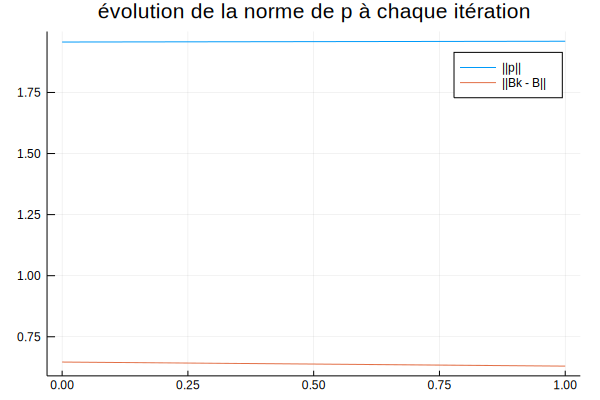

In [254]:
Δ = 5
p, S, iter, P, normB = lineSearch(tridiag, x₀, Δ);

println("p = $p")
println("||p|| = ", norm(p))
println("||g(x₀ + p)|| = ", norm(tridiag.gradient(x₀ + p)))

plot(0:iter, S, label = "||p||", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")

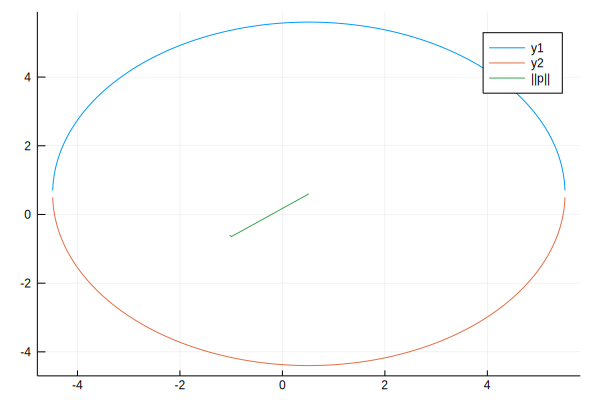

In [255]:
x = [x₀[1]]
y = [x₀[2]]
for i= 1:length(P)
    push!(x, P[i][1] + x₀[1])
    push!(y, P[i][2] + x₀[2])
end
f1 = []
f2 = []
X = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
for x = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
    push!(f1, sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
    push!(f2, -sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
end
plot(X, f1)
plot!(X, f2)
plot!(x, y, label = "||p||")

In [256]:
# Exemple en dimension 2 avec affichage graphique
# Création d'une matrice particulière (creuse)
N = 2
quadratic = createQuadraticConvexe(N)
x₀ = rand(N)
A = quadratic.Hess(x₀)
println(norm(A)*norm(inv(A)))

1625.1304007479807


   dₖᵗBdₖ   dₖᵗBₖdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||  ||B-Bₖ|| 
 1.2e+01  6.7e+00 -6.7e+00  5.5e-01 -1.2e-01  1.4e+00  1.4e+00 
sortie de la région de confiance :  -1.2e-01  1.4e+00 
p = [-1.03939, -0.93791]
||p|| = 1.4000000000000001
||g(x₀ + p)|| = 0.5270031172750123


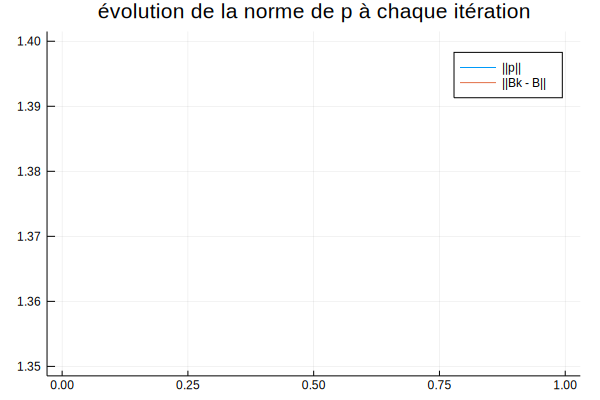

In [257]:
Δ = 1.4
p, S, iter, P, normB = lineSearch(quadratic, x₀, Δ);

println("p = $p")
println("||p|| = ", norm(p))
println("||g(x₀ + p)|| = ", norm(quadratic.gradient(x₀ + p)))

plot(0:iter, S, label = "||p||", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")

In [655]:
print(S)

[1.31397, 1.4]

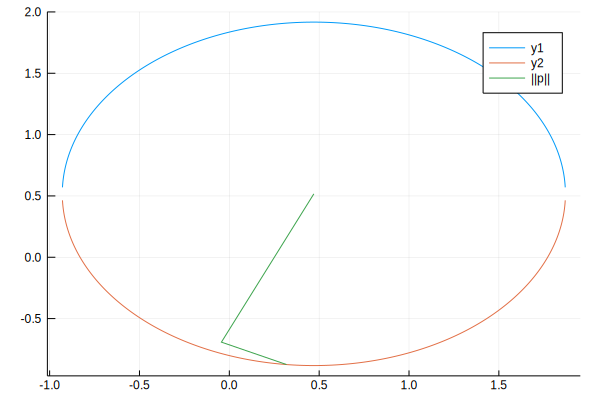

In [656]:
x = [x₀[1]]
y = [x₀[2]]
for i= 1:length(P)
    push!(x, P[i][1] + x₀[1])
    push!(y, P[i][2] + x₀[2])
end
f1 = []
f2 = []
X = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
for x = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
    push!(f1, sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
    push!(f2, -sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
end
plot(X, f1)
plot!(X, f2)
plot!(x, y, label = "||p||")

In [658]:
T = zeros(length(P) - 1, N) # les sₖ
for i = 2:length(P)
    for j = 1:N
        T[i - 1, j] = P[i][j] - P[i-1][j]
    end
end
A = quadratic.Hess(x₀)
print(T*A*transpose(T))

[0.038636]

2.449489742783178